## Nonlinear MPC with Kinematic Bicycle Model

The bicycle model is the same one used in <a href=https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4>this paper (Figure 3)</a>

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [1]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
#import bezier

# Local dependencies
from trajectory_planner import TrajectoryPlanner
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

In [2]:
# Generates a totally straight test_road
'''
test_road = np.ones((100,2))
for i in range(100):
    test_road[i,0] = i
#from road import iso_double_lane_change as test_road
'''
from road import iso_double_lane_change as test_road
# Flips the test road, so the car goes from the end to the start.
#test_road = np.flip(test_road, 0)

test_road_width = 2.5*np.ones(np.size(test_road)//2)

## Initialize the car and road model

In [3]:
# Initialize the car model with 0.075 second steps and 30 step lookahead
params = {"step":0.075,
          "N":30,
          "n":4, # 4 states
          "m":2, # 2 control inputs
         }
planner = TrajectoryPlanner(**params)

In [4]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        road_width  = test_road_width,
                        P           = np.size(test_road_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time

roadrunner.advance(2)

 [  0.]] is 10.0 away at s = 1.0, B(s) = [[290.]
 [  0.]]


## Boundary functions
We represent the road boundaries as a series of polygons. At each step $x_k$, $x_{k+1},...,x_N$, the car's x-y position is bounded by a 4-sided polygon.
The polygons for successive states overlap, allowing the car to steer and slow down / speed up within the confines of the road.

This image shows 5 successive bounds from $k$ to $k+5$. The $k+5^{th}$ bound is in red.
![title](polygon_bounds.png)

In [5]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints - done
# 3. Use the midpoints to initialize the variable estimate so the solver is faster. - done,
#    and we are initializing the new control uk to the previously computed one
#    kind of warm-starting ipopt - done

In [6]:
# stop sign test
'''
DESIRED_SPEED = 4.0
stop_sign = (10.0,1.0) # x,y
stop_s = roadrunner.find_closest(stop_sign)

def dist_to_stop_line(xy):
    x0, y0 = stop_sign
    x,y = xy
    dist = np.sqrt((y-y0)**2 + (x-x0)**2)*np.cos(np.arctan2(y0-y, x0-x))
    return dist

stop_dist = 0.0 # meters, distance to stop sign when we should stop

def desired_speed(k:int, x, y):
    xy = np.array([x,y])
    # 1: Find closest point to xy on road centerline
    dist = dist_to_stop_line(xy)
    # 3: Linear relationship between distance and speed
    if np.abs(dist) > 10:
        return DESIRED_SPEED
    elif dist < 0.05:
        return np.max([0, np.abs(DESIRED_SPEED*(dist-0.1-stop_dist)/10.0)])
    else:
        return np.max([0, np.abs(DESIRED_SPEED*(dist-stop_dist)/10.0)])
'''
DESIRED_SPEED = 10.0
def desired_speed(x, y, k):
    return DESIRED_SPEED


In [7]:
def driveable_corridor(x, y, s):
    state = roadrunner.save_state()
    step = roadrunner.advance_xy(np.array([x,y]))
    xy, angle, width = roadrunner.evaluate(s, full_data=True)
    xy = np.reshape(xy, 2)
    roadrunner.reset(**state)
    return xy[0], xy[1], angle[0], width, width

In [8]:
def constraint_generator(z, k):
    def g(zk, index):
        return -1 # it has to be <= 0

In [9]:
xy, angle, width = roadrunner.evaluate(full_data=True)
ic = np.array([xy[0,0], xy[0,1], desired_speed(xy[0,0], xy[0,1], 0), angle[0]])
print(ic)

[-7.42889679e+01  1.79186452e-21  1.00000000e+01  5.22764958e-21]


## Run the MPC algorithm

### Cost weights

In [10]:
weights = {
       "accuracy":1.0,
           "jerk":250.0,
"steering change":25.0,
   "acceleration":250.0,
}
# use acceleration weight for stopping scenario and decrease accuracy by 10x


# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 100

10.0


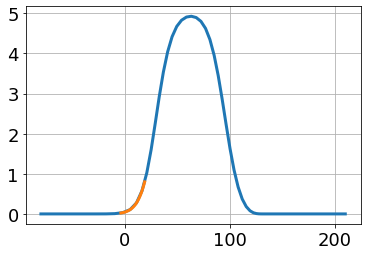

In [11]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(40)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], desired_speed(0, xy[0], xy[1]), float(roadrunner.get_angle())]
planner.mpcprob.model.set_initial(ic, desired_speed, roadrunner)

planner.setup_to_save_data(n_runs)
planner.z0 = ic
estimated_path, _, _ = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
planner.initialize_first_mpc_problem(estimated_path)

planner.mpcprob.roadrunner = roadrunner
planner.mpcprob.model.desired_speed = desired_speed

fig, ax = plt.subplots(1,1)
roadrunner.plot(ax=ax, n_points=50)
ax.plot(estimated_path[0,:], estimated_path[1,:])

print(desired_speed(0, ic[0], ic[1]))

<IPython.core.display.Javascript object>


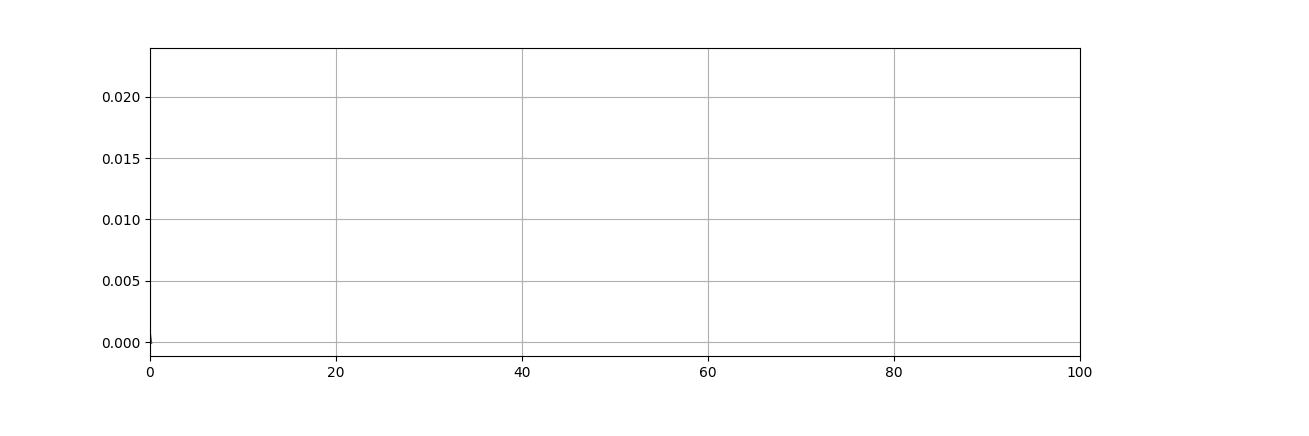

z0 [-3.80120106e+00  2.28331073e-02  1.00000000e+01  4.36620729e-03]


IndexError: index 2 is out of bounds for axis 0 with size 2

In [12]:
%matplotlib notebook

# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+params["N"],4,2))

fig_traj = plt.figure(figsize=(12,4))
ax_traj = fig_traj.add_subplot(111)

plt.ion()
fig_traj.show()

states = ax_traj.plot(planner.x_true[0], planner.x_true[1], color="red")[0]
#ax_traj.quiver(x_true[0,0], x_true[1,0], x_true[2,0]*np.cos(x_true[3,0]), x_true[2,0]*np.sin(x_true[3,0]), color="blue")
plt.xlim([0,100])

fig_traj.canvas.draw()

k = 0
# test: hack? TODO fix, July 20th, 2021
#mpcprob.weights["acceleration"] = 100.
#acc = mpcprob.weights["accuracy"]

try:
    while k < n_runs:
        # July 20th, 2021
        #if k < 5:
            #mpcprob.weights["accuracy"] = (k)/4.0*acc
            #mpcprob.weights["acceleration"] -= 20.
        print("z0", planner.z0)
        estimated_path, left_widths, right_widths = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
        # Solve the MPC problem
        problem = planner.build_mpc_problem(estimated_path, left_widths, right_widths, weights)
        xk_opt, uk_opt, sol = planner.solve_mpc_problem(problem)
        
        # for plotting
        planner.centers[:,k+1] = planner.mpcprob.x_center_plot[:,1]


        # Save the next state x_k+1 and control u_k+1
        for i in range(params["n"]):
            planner.x_plan[i,k+1] = xk_opt[i][1]
        for i in range(params["m"]):
            planner.u_plan[i,k] = uk_opt[i][1]
        _,p = planner.mpcprob.bound_x(estimated_path[0,k], estimated_path[1,k], estimated_path[3,k], left_widths[k], right_widths[k])
        planner.polygon_boundaries[k,:,:] = p
        planner.x_true[:,k+1] = planner.apply_control(planner.u_plan[:,k])
        planner.z0 = planner.x_true[:,k+1]
        
        planner.initialize_nth_mpc_problem(xk_opt, uk_opt)
    
    
        # Advance the roadrunner to our new state at k+1
        step_xy = roadrunner.advance_xy(planner.x_true[0:2,k+1])

        print("Advanced by", step_xy,"to", roadrunner.evaluate())

        # for plotting
        # Plot arrows and x-y states
        ax_traj.clear()
        ax_traj.scatter(planner.x_true[0,:k], planner.x_true[1,:k], color="navy")
        xy = np.reshape(roadrunner.evaluate(),(2,1))
        ax_traj.scatter(xy[0], xy[1], color="red")
        # Plot the polygon fill
        ax_traj.fill(planner.polygon_boundaries[k,:,0], planner.polygon_boundaries[k,:,1], "lightblue", alpha=0.5)
        # Plot the line around each polygon
        ax_traj.plot(np.concatenate([planner.polygon_boundaries[k,:,0],planner.polygon_boundaries[k,0:1,0]]),
                np.concatenate([planner.polygon_boundaries[k,:,1],planner.polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.5)


        ax_traj.scatter(xk_opt[0], xk_opt[1], color="orange")
       # ax_traj.scatter(stop_sign[0], stop_sign[1], color="red")

        roadrunner.plot(ax=ax_traj, n_points=50)
        
        fig_traj.canvas.draw()
        # Done!

        if not sol['success']: # it failed
            print("FAILED: ipopt returned status", sol['success'], "\n", sol['return_status'])
            raise ValueError("ipopt failed and I need to make a better exception name")
        
        k += 1
        '''
        # stop sign test??
        
        idx = xk_opt[0].size-1
        xy_last = np.array([xk_opt[0][idx], xk_opt[1][idx]])
        dist = dist_to_stop_line(xy_last)
        print("\n\ndist", dist)
        mpcprob.indices_to_stop = None
        while dist <= stop_dist and idx >= 0 and mpcprob.indices_to_start is not None:
            mpcprob.indices_to_stop = idx
            
            print("\n\nStopping index", idx)
            idx -= 1
            xy_last = np.array([xk_opt[0][idx], xk_opt[1][idx]]) 
            dist = dist_to_stop_line(xy_last)
        
        # restart test??
        if mpcprob.indices_to_stop == 0: # car is at a stop
            # now begin moving forward
            mpcprob.indices_to_stop = None
        '''
except OutOfRoadPointsException as e:
    print(e)
    planner.x_plan = planner.x_plan[:,:k+1] # Cut the vectors shorter so they don't have unitialized values
    planner.u_plan = planner.u_plan[:,:k]  
    planner.x_true = planner.x_true[:,k+1]
    planner.centers = planner.centers[:,k+1]
    # store the polygon boundary for each step, so we can plot them later
    polygon_boundaries = polygon_boundaries[:k+N,:,:]
finally:
    fig_traj.canvas.draw()


In [ ]:
# turn interactive off
plt.ioff()
planner.x_plan = planner.x_plan[:,:k+1] # Cut the vectors shorter so they don't have unitialized values
planner.u_plan = planner.u_plan[:,:k]  
planner.x_true = planner.x_true[:,k+1]
planner.centers = planner.centers[:,k+1]
    

In [ ]:
print(left_widths)

## Control signals: acceleration and steering angle

In [ ]:
from KinematicBicycleCar import plot_u
u_plt, u_ax1, u_ax2 = plot_u(planner.u_plan, planner.mpcprob.u_opt, params["step"], params["N"])

plt.show()

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

In [ ]:
from KinematicBicycleCar import plot_x
x_plt, x_ax = plot_x(planner.x_plan, planner.mpcprob.x_opt, params["step"], params["N"], figsize=(12,3))
    
roadrunner.plot(ax=x_ax, n_points=50)
plt.ylim(-5,15)
plt.show()

## x vs time and y vs time, separately, with the boundaries

In [ ]:
# Plot the road boundary as polygons
def plot_polygons(polygon_boundaries, ax=None):
    n_polys,_,_ = np.shape(polygon_boundaries)
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(12,4))
        
    for k in range(n_polys):
        # Plot the polygon fill
        ax.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.1)
        # Plot the line around each polygon
        ax.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.25)

    # Plot the last polygon in RED
    ax.plot(np.concatenate([polygon_boundaries[-1,:,0],polygon_boundaries[-1,0:1,0]]),
            np.concatenate([polygon_boundaries[-1,:,1],polygon_boundaries[-1,0:1,1]]),
            color="red", alpha=0.5)
    return ax

ax = plot_polygons(polygon_boundaries)
ax.scatter(ic[0], ic[1], color="green")
plt.title("Polygon boundaries along road")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(step*np.arange(np.size(x_plan[2])), x_plan[2])
plt.show()

In [ ]:
for x in np.transpose(x_plan):
    print("["+",".join([str(xi) for xi in x])+"],")
for x in np.transpose(mpcprob.x_opt):
    print("["+",".join([str(xi) for xi in x])+"],")
    

In [ ]:
for x in np.transpose(u_plan):
    print("["+",".join([str(xi) for xi in x])+"],")
for x in np.transpose(mpcprob.u_opt):
    print("["+",".join([str(xi) for xi in x])+"],")
    

In [ ]:
print(mpcprob.indices_to_stop)